# Solvent-accessible surfaces vs solvent-excluded surfaces

The concept of a solvent-excluded surface is intuitive, but it's difficult to calculate.

A starting point is the hard-sphere approximation of a molecule. In this approximation, each atom is a perfect sphere with radius defined by the van Der Waals radius. 

The solvent-accessible surface (SAS) is similar to the hard-sphere surface, but removes any surfaces on the internal parts of the molecule, as well as tiny crevices on the external parts. Imagine a probe sphere rolling around the surface of a molecule. The SAS is the shape defined by the probe's path. It's reasonably easy to calculate SAS-area (SASA) using the [Shrake-Rupley](https://en.wikipedia.org/wiki/Accessible_surface_area) algorithm.

A related concept is the solvent-excluded surface (SES), which is where life gets difficult. The SES is the hard sphere approximation when there is room for a probe sphere to contact an atom surface. Inbetween two atoms, however, the SES becomes the surface of the probe sphere, which is known as a re-entrant surface. The canonical analytical approach to calculating it is by Connolly's approach ([doi](https://doi.org/10.1107/S0021889883010985)), which uses hourglass-shaped patches to fill the SES between atoms.

### Here's an outline of the three surfaces from the Chimera docs:

![bah](https://www.cgl.ucsf.edu/chimerax/docs/user/commands/surface-diagram.png)

# Molecular volume

Arguably, the best overlap between two ligands is the one that maximises their overlapping volume. The union of atomic volumes can be calculated analytically with geometry, and a famous paper by Andrew Grant ([doi](https://doi.org/10.1002/(SICI)1096-987X(19961115)17:14<1653::AID-JCC7>3.0.CO;2-K)) showed how to do it with a Gaussian approximation of the atoms. This is nice in that the volume overlap has a gradient, and the 'fuzziness' kind of represents an electron cloud. 

But that's the union of atomic volumes. The volume of a molecule also includes the excluded spaces between atoms, and a protein shouldn't care whether the actual atoms overlap or not. 

Instead, this notebook shows how to calculate SES's and their volumes. The SES is approximated with a mesh, and there is a handy and fast algorithm for calculating the volume of a watertight mesh ([doi](https://doi.org/10.1109/ICIP.2001.958278)).

To make life simple, we start in the 2d case.


In [268]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.interpolate import Rbf

# SETUP
Generate two 'atoms' - really just 2D point clouds sampled from the surfaces of two circles. We will also copy those points and expand their distance from the atom centres by one 'probe radius' to sample points from the SAS.

Note: for the rest of the notebook, the atom-surface points will be **BLUE**, and the SAS/SES points will be **ORANGE**.

In [269]:
def plot_points(p, ep):
    """Plots the surface points (p) and extended surface points (ep)"""
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax.scatter(*p.T, s=80)
    ax.scatter(*ep.T, s=80)



    ax.set_xlim(0,len(xx))
    ax.set_ylim(0,len(xx))
    ax.set_aspect('equal')
    return fig, ax 

In [328]:
class SESMesh(object):
    def __init__(self, proberad=1.4):
        self.PROBERAD = proberad
    
    def circle_points(self, num_pts, radius=1):
        """Sample points spread out around a 2D unit circle"""
        t = np.linspace(0, 2*np.pi, num_pts, endpoint=False)
        x = radius * np.cos(t)
        y = radius * np.sin(t)
        
        self.template_points = np.c_[x, y]
    
    def golden_spiral(self, num_pts, radius=1):
        """Sample points spread out around a 3D unit sphere surface
        See stackoverflow post: ###"""
        indices = np.arange(0, num_pts, dtype=float) + 0.5
        phi = np.arccos(1 - 2*indices/num_pts)
        theta = np.pi * (1 + 5**0.5) * indices
        x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
        points = np.vstack([x,y,z]).T
        
        self.template_points = points*radius
    
    def generate_points(self, positions, radii):
        """This function samples points on the surface of the atoms (blue, surface point)
        as well as on the extended surface (orange).
        
        The logic is that you first repeat the spherical surface points by the number of atoms.
        Then multiply them all by the radii. Since they're all still centred on zero, they just
        assume the shapes of the atoms now. Then, translate them all by the atom coordinates.
        """
        self.positions = positions
        self.radii = radii
        
        n = self.template_points.shape[0]
        ##repeat the atomic radii by 'n' to keep track of how far each blue point should be from 
        ##its parent atom.
        self.all_radii = np.repeat(radii, n)

        ##repeat the surface points, and then multiply by atomic radii
        sp = np.tile(self.template_points, (positions.shape[0],1)) * np.repeat(radii, n)[:,None]
        ##now translate by positions
        self.sp = sp+np.repeat(positions, n,axis=0)

        ##similarly, repeat the surface points and multiply by atomic radii + PROBERAD
        ep = np.tile(self.template_points,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
        #now transform by positions
        self.ep = ep+np.repeat(positions, n,axis=0)
        
        
    def remove_bad_surface_points(self):
        """
        This calculates the distance between surface points and the atom centres. 
        If a point-atom distance is less than an atom radius, then the surface point
        must be within another atom. Delete those points by masking.
        """
        #remove any blue surface point that is inside another atom 
        dmat = cdist(self.sp, self.positions)
        inside = ((dmat-radii)+0.00001).min(1) < 0

        #apply the mask:
        self.sp = self.sp[~inside]
        
    def remove_bad_extended_points(self):
        """
        Same as `remove_bad_surface_points` but for extended points.
        This calculates the distance between extended points and the atom centres. 
        If a point-atom distance is less than an atom radius plus the probe radius, 
        then the surface point must be too close to the atom surface. 
        Delete those points by masking.
        """
        #remove any orange extended points that you could not 
        #centre a probe atom on.
        dmat = cdist(self.ep, self.positions) - self.radii
        too_close = dmat.min(1)<(self.PROBERAD-0.000001)

        #apply the mask
        self.ep = self.ep[~too_close]
        
    def translate_reentrant_surfaces(self):
        """
        This identifies any surface point that is _more_ than one PROBERAD
        away from its closest extended point. That means this surface point must be
        hidden within a reentrant surface. 
        It then finds the vector pointing to the nearest extended point, and
        translates each hidden surface point to be exactly one PROBERAD away. 
        """
        dmat = cdist(self.ep, self.sp)
        
        surface_idx = dmat.min(0)>(self.PROBERAD+0.0001)
        extended_idx = dmat[:,surface_idx].argmin(0)

        vec = self.ep[extended_idx] - self.sp[surface_idx]

        scaling = 1 - (self.PROBERAD / np.linalg.norm(vec,axis=1))
        self.sp[surface_idx] +=(scaling[:,None]*vec)
        
    def sample_sdf(self):
        
        surface_distances = np.zeros(self.sp.shape[0])
        extended_distances = np.ones(self.ep.shape[0])*self.PROBERAD
        
        self.sampled_coords = np.vstack([sesmol.sp,sesmol.ep, sesmol.positions])
        self.sampled_sdf = np.hstack([surface_distances,extended_distances, -self.radii])


        
    def gen_grid(self, gridsize=0.5, buf=None):
        if buf is None:
            buf = self.PROBERAD 
        
        min_coords = self.sampled_coords.min(0)-buf
        max_coords = self.sampled_coords.max(0)+buf
        self.max_coords = max_coords + (gridsize - (max_coords)%gridsize)
        self.min_coords = min_coords - (gridsize + (min_coords)%gridsize)
        
        self.bins = list()
        
        for dim in range(len(self.min_coords.shape)+1):
            grid = np.linspace( self.min_coords[dim], 
                               self.max_coords[dim], 
                               int((self.max_coords[dim]-self.min_coords[dim])/gridsize+1)
                              )
            self.bins.append(grid)
            
        self.mgrid = np.meshgrid(*self.bins)
        self.grid = [i.ravel() for i in self.mgrid]
        
    def interp(self):
        r = Rbf(*self.sampled_coords.T, self.sampled_sdf)
        self.sdf = r(*self.grid).reshape(self.mgrid[0].shape)
        

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

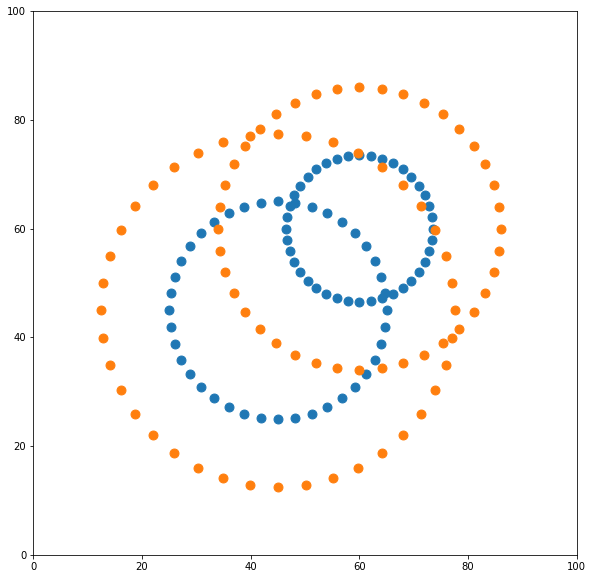

In [343]:
#create an underlying grid
xx = np.linspace(0,100, 100)
#set the coordinates of two 'atoms', which lie somewhere on the grid.
positions = np.array([[xx.max()*.45,xx.max()*.45], [xx.max()*.60,xx.max()*.60]])
#set some radii for the atoms. I just chose some nice numbers
radii = np.array([ xx.max()*0.20, xx.max()*0.135])

#the radius of the probe circle.
PROBERAD = xx.max()*.125



#init object
sesmol = SESMesh(PROBERAD)
#generate a 2d template:
sesmol.circle_points(40)
#plt.scatter(*sesmol.template_points.T)

#generate surface and extended points for two atoms (defined above)
sesmol.generate_points(positions, radii)
plot_points(sesmol.sp, sesmol.ep)



(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

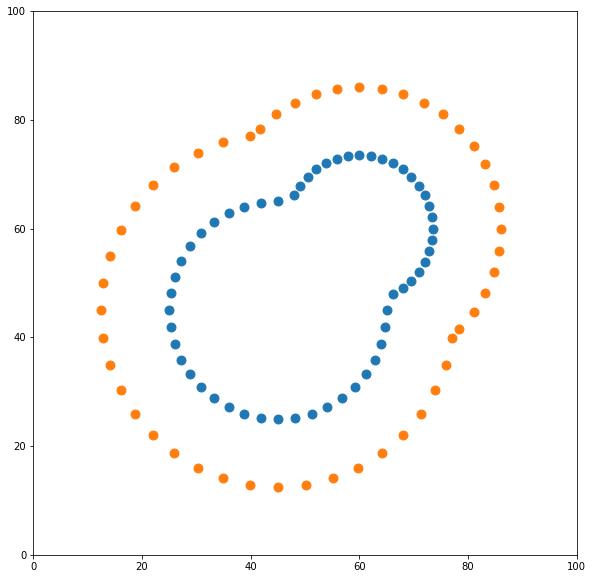

In [344]:
sesmol.remove_bad_surface_points()
sesmol.remove_bad_extended_points()
plot_points(sesmol.sp, sesmol.ep)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

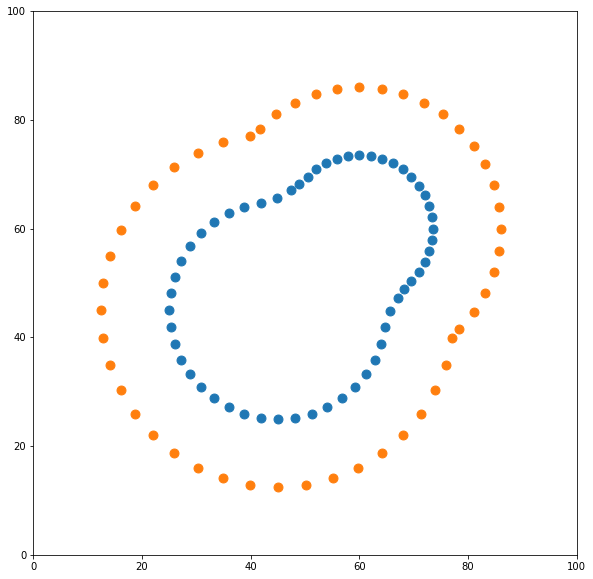

In [345]:
sesmol.translate_reentrant_surfaces()
plot_points(sesmol.sp, sesmol.ep)

# Interpolate these points onto a grid.
Thanks to the translation step for the re-entrant surfaces, we now know that each blue point will have zero distance to the SES. Likewise, we know each orange probe point sits exactly one probe-radius distance from the SES. We can add one more bit of detail - the atomic centres are one negative atom radius from the SES. 

This is enough information to interpolate a signed-distance field, which will then be used to create a mesh. 



In [346]:
sesmol.sample_sdf()
sesmol.gen_grid(gridsize=1)
sesmol.interp()

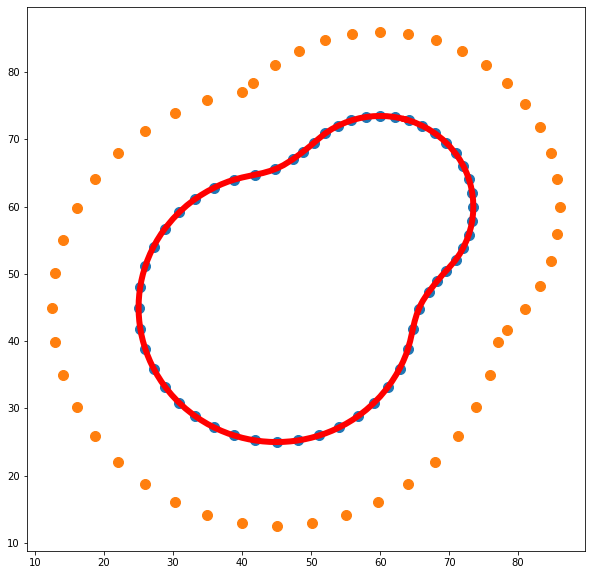

In [348]:
fig,ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
contours = find_contours(sesmol.sdf, 0)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1]+sesmol.min_coords[0], contour[:, 0]+sesmol.min_coords[1], linewidth=6, c='red')



ax.scatter(*sesmol.sp.T,s=100,c='C0')
ax.scatter(*sesmol.ep.T,s=100,c='C1')

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

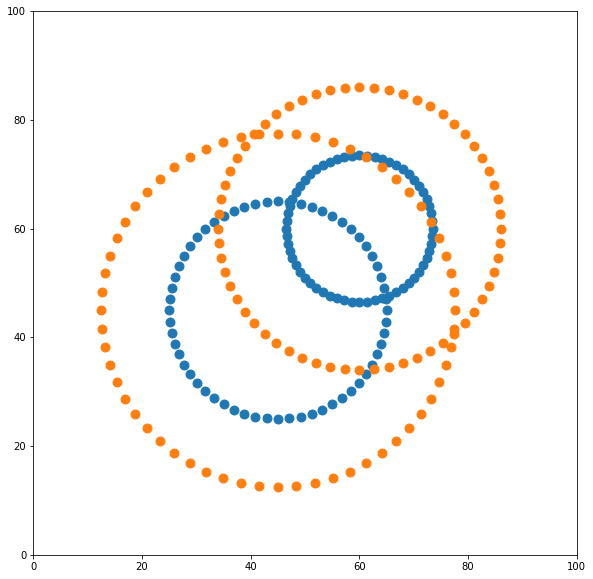

In [1008]:
def circle_points(r, n):
    """Sample points spread out around a unit circle"""
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

#num points:
n = 60
#get the points:
pts = circle_points([1], [n])[0]



#create an underlying grid
xx = np.linspace(0,100, 100)
#set the coordinates of two 'atoms', which lie somewhere on the grid.
positions = np.array([[xx.max()*.45,xx.max()*.45], [xx.max()*.60,xx.max()*.60]])
#set some radii for the atoms. I just chose some nice numbers
radii = np.array([ xx.max()*0.20, xx.max()*0.135])

#the radius of the probe circle.
PROBERAD = xx.max()*.125

###
##Now construct the atoms - this just uses numpy to repeat the `pts` while 
##multiplying them by the radii or the radii+PROBERAD to get surface points
##and SAS points
###

##calculate the radius associated with each point, aka distance from nearest atom.
all_radii = np.repeat(radii, n)

##surface points:
#repeat the points and multiply by radii
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
#now transform by positions
p = t+np.repeat(positions, n,axis=0)

#repeat the points and multiply by radii
ep = np.tile(pts,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
#now transform by positions
ep = ep+np.repeat(positions, n,axis=0)


plot_points(p, ep)

# Remove points that lie inside another atom.

These are the easy ones. Simply calculate the minimum distance between a blue point and the atom coordinates. If it's less than the radius of that atom, get rid of it.

Note: you can see some blue points that are actually within 

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

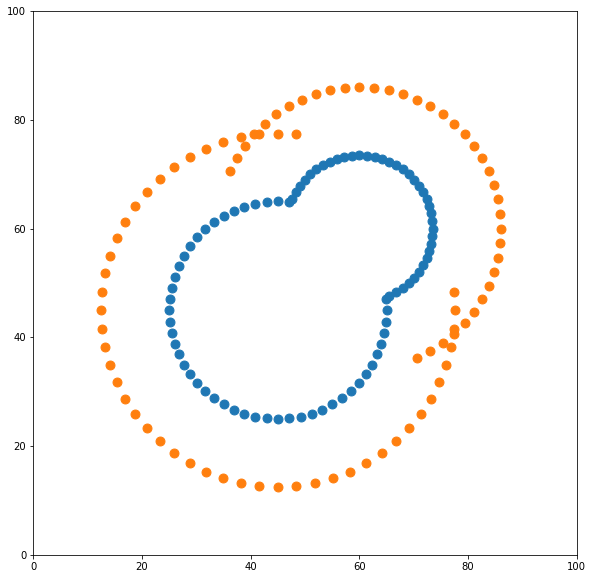

In [1009]:
#remove any blue point that is inside another atom (and also their attendant orange points.)
dmat = cdist(p, positions)
#inside = dmat.min(1)<(all_radii-0.000001)
inside = ((dmat-radii)+0.00001).min(1) < 0

#apply the mask:
p = p[~inside]
ep = ep[~inside]

#also apply it to the radii associated with the blue points:
all_radii = all_radii[~inside]

plot_points(p, ep)

# Remove any SAS points (orange) where a probe sphere couldn't fit

The orange points represent the centre of a probe sphere. So if a point is within one probe radius of a blue point, get rid of it. 


NOTE TO SELF: instead of doing the ep, p distmat, just do ep, positions distmat. Then subtract the probe radius (broadcasting along the EP axis). THEN, all points below zero should be removed This may solve issues with orange points existing inside the molecule!

NOTE TO SELF: Also, later, use Scipy RBF instead. 

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

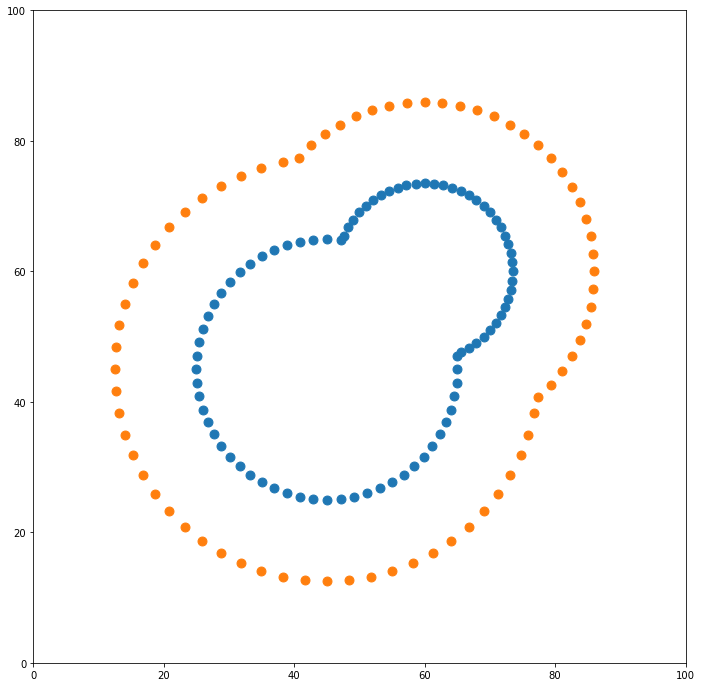

In [23]:
#now remove any orange point that is too close to a blue point. 

dmat = cdist(ep, p)
too_close = dmat.min(1)<(PROBERAD-0.000001)

ep = ep[~too_close]
dmat = dmat[~too_close]

plot_points(p, ep)

# Now translate the problematic blue points to be 1 probe radius from their nearest probe

In [26]:
blue_idx = dmat.min(0)>(PROBERAD+0.0001)
orange_idx = dmat[:,blue_idx].argmin(0)

vec = ep[orange_idx] - p[blue_idx]

scaling = 1 - (PROBERAD / np.linalg.norm(vec,axis=1))
p[blue_idx] +=(scaling[:,None]*vec)

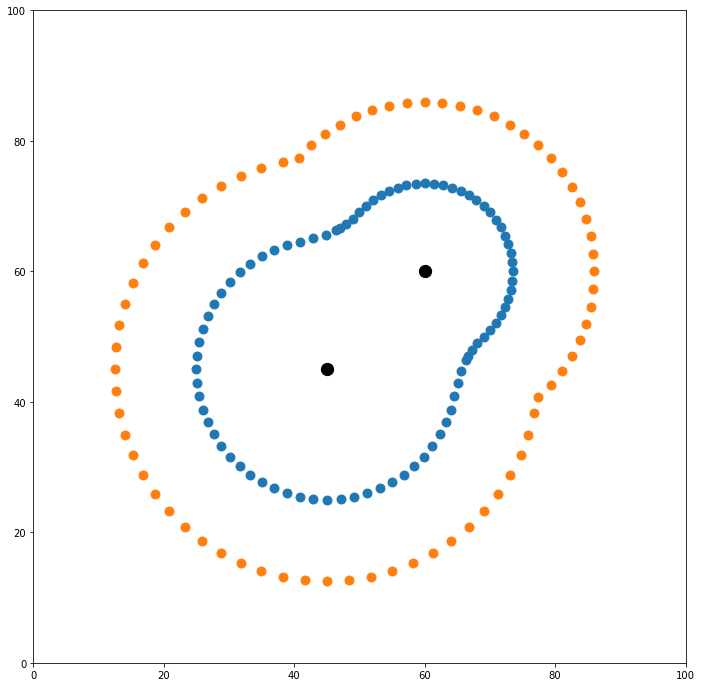

In [27]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)

ax.scatter(*p.T, s=80)
ax.scatter(*ep.T, s=80)
ax.scatter(*positions.T, s=150, c='k')


ax.set_xlim(0,len(xx))
ax.set_ylim(0,len(xx))
ax.set_aspect('equal')

# Interpolate onto a grid:
We already know that all the blue points are on the atom surface, so they have a surface distance of zero. Likewise we know that, after shifting those blue points, all the orange points are one probe radius away from the solvent-excluded surface.

In order to turn this into a volume mesh, we need a signed distance field (SDF), which is a regular grid (a 3D array) where each value is the distance from the grid coordinate to the solvent-excluded surface. `scipy.interpolate.griddata` can do this if given the grid coordinates and the values of the distances from some points within the grid.

To help it along, we add a point at each atom position with the value of `-radius`, which is the signed distance from the solvent-excluded surface.



In [28]:
blue_distances = np.zeros(p.shape[0])
orange_distances = np.ones(ep.shape[0])*PROBERAD

pts3 = np.vstack([p,ep, positions])
z3 = np.hstack([blue_distances,orange_distances, -radii])



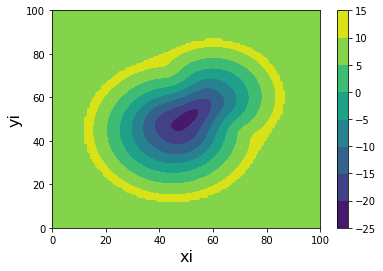

In [29]:
from scipy.interpolate import griddata

a,b = np.meshgrid(xx, xx)
grid = np.stack((a.ravel(), b.ravel()),axis=1)


# interpolate
zi = griddata((pts3[:,0], pts3[:,1]),z3, (a,b),method='cubic', fill_value = 10)

# # mask out the field
# zi[mask] = np.nan

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(a,b,zi,)

plt.xlabel('xi',fontsize=16)
plt.ylabel('yi',fontsize=16)
plt.colorbar()




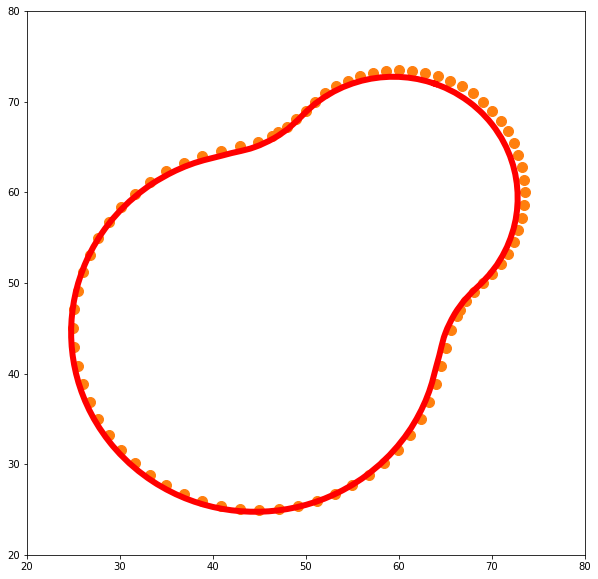

In [30]:
fig,ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
contours = find_contours(zi, 0)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=6, c='red')

# ax.set_xlim(0,xx.max())
# ax.set_ylim(0,xx.max())
ax.set_xlim(20,80)
ax.set_ylim(20,80)
ax.scatter(*p.T,s=100,c='C1')


# Try a molecule!

In [182]:
def golden_spiral(num_pts, radius=1):

    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius



n = 60

pts = golden_spiral(n)

In [183]:
from mol3d import Mol3D
from rdkit import Chem

mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol.embed3d(1, hydrogens=True)

positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])#+0.1


In [184]:
PROBERAD = 1.4

In [185]:
#add points:

##calculate the radius associated with each point.
all_radii = np.repeat(radii, n)


##surface points:
#repeat the points and multiply by radii
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
#normals are easy because the points were already from the origin:
normals = np.tile(pts,(len(positions),1))

#now transform by positions
p = t+np.repeat(positions, n,axis=0)

#repeat the points and multiply by radii
et = np.tile(pts,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
#now transform by positions
ep = et+np.repeat(positions, n,axis=0)

In [186]:
#first remove any blue point that is inside another atom (and also their attendant orange points.)

dmat = cdist(p, positions)
#inside = dmat.min(1)<(all_radii-0.000001)
inside = ((dmat-radii)+0.00001).min(1) < 0

#

p = p[~inside]
ep = ep[~inside]
normals = normals[~inside]

all_radii = all_radii[~inside]


In [187]:
#now remove any orange point that is too close to a blue point. 

dmat = cdist(ep, p)
too_close = dmat.min(1)<(PROBERAD-0.000001)

ep = ep[~too_close]
dmat = dmat[~too_close]


In [188]:
blue_idx = dmat.min(0)>(PROBERAD+0.0001)
orange_idx = dmat[:,blue_idx].argmin(0)
vec = ep[orange_idx] - p[blue_idx]
scaling = 1 - (PROBERAD / np.linalg.norm(vec,axis=1))
p[blue_idx] +=(scaling[:,None]*vec)

In [189]:
pts3 = np.vstack([p,ep, positions])
z3 = np.hstack([np.zeros(p.shape[0]),np.ones(ep.shape[0])*PROBERAD, -radii])



In [190]:
buff = max(radii)+0.6

x1, y1, z1 = np.rint((positions.min(0)-buff)*10)/10
x2, y2, z2 = np.rint((positions.max(0)+buff)*10)/10

spacing = 0.25
x = np.arange(x1, x2, spacing)
y = np.arange(y1, y2, spacing)
z = np.arange(z1,z2, spacing)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

In [194]:
x

array([-8.9 , -8.65, -8.4 , -8.15, -7.9 , -7.65, -7.4 , -7.15, -6.9 ,
       -6.65, -6.4 , -6.15, -5.9 , -5.65, -5.4 , -5.15, -4.9 , -4.65,
       -4.4 , -4.15, -3.9 , -3.65, -3.4 , -3.15, -2.9 , -2.65, -2.4 ,
       -2.15, -1.9 , -1.65, -1.4 , -1.15, -0.9 , -0.65, -0.4 , -0.15,
        0.1 ,  0.35,  0.6 ,  0.85,  1.1 ,  1.35,  1.6 ,  1.85,  2.1 ,
        2.35,  2.6 ,  2.85,  3.1 ,  3.35,  3.6 ,  3.85,  4.1 ,  4.35,
        4.6 ,  4.85,  5.1 ,  5.35,  5.6 ,  5.85,  6.1 ,  6.35,  6.6 ,
        6.85,  7.1 ,  7.35,  7.6 ,  7.85,  8.1 ,  8.35,  8.6 ,  8.85,
        9.1 ,  9.35,  9.6 ,  9.85])

In [193]:
y.shape

(41,)

In [60]:
%%time
zi = griddata((pts3[:,0], pts3[:,1], pts3[:,2]), z3, (a,b,c),method='linear', fill_value = PROBERAD)



CPU times: user 3.08 s, sys: 32.9 ms, total: 3.11 s
Wall time: 2.55 s


In [41]:
def estimate_volume(pos, n):
    x1, y1,z1 = np.min(spheres,0)-2.5
    x2, y2,z2 = np.max(spheres,0)+2.5
    x = np.random.uniform(x1, x2, n)
    y = np.random.uniform(y1, y2, n)
    z = np.random.uniform(z1, z2, n)
    s = np.vstack([x,y,z]).T
    dis = (cdist(s, spheres) - radii).min(1)
    i = (dis<0).sum()
    return (i / n) * ((x2-x1) * (y2-y1) * (z2-z1))

    
    
spheres = mol.mol.GetConformer(0).GetPositions()

sizes = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 5000, 10_000, 12500, 15000, 20000]
results = {}
repeats = 5
for size in sizes:
    results[size] = []
    for i in range(repeats):
        vol = estimate_volume(spheres, size)
        results[size].append(vol)

In [42]:
[estimate_volume(spheres, int(1e6)) for _ in range(10)]

[300.02739383559765,
 300.4845592553035,
 301.6667447238821,
 300.2690671852219,
 302.3696113823726,
 300.66782821210194,
 300.8067903881358,
 302.46225283306194,
 301.5116709912066,
 301.21562113791686]

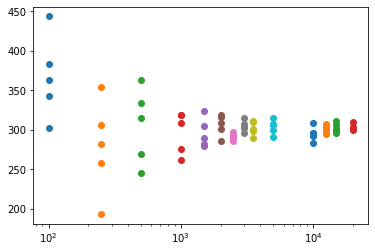

In [43]:
for size in sizes:
    plt.scatter(np.ones(repeats)*size, results[size])
plt.xscale('log')


In [44]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

In [45]:
%%time

interp = LinearNDInterpolator(list(zip(pts3[:,0], pts3[:,1], pts3[:,2])), z3, fill_value=2)
zi = interp(grid)
zi = zi.reshape(a.shape)

CPU times: user 1.07 s, sys: 26.7 ms, total: 1.1 s
Wall time: 561 ms


In [46]:
%%time
(interp(s)<0).sum() / len(s)

NameError: name 's' is not defined

In [47]:
from rdkit.Chem.AllChem import ComputeMolVolume
ComputeMolVolume(mol.mol, 0)

300.58400000000006

In [48]:
%%time
x1, y1, z1 = vert.min(0)
x2, y2, z2 = vert.max(0)
spacing = 20
x = np.linspace(x1, x2, spacing)
y = np.linspace(y1, y2, spacing)
z = np.linspace(z1,z2, spacing)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

vals = interp(grid)

NameError: name 'vert' is not defined

In [56]:
import meshplot as mp

In [61]:
%%time
import igl 


n=500
x1, y1,z1 = np.min(vert,0)-1.5
x2, y2,z2 = np.max(vert,0)+1.5
x = np.random.uniform(x1, x2, n)
y = np.random.uniform(y1, y2, n)
z = np.random.uniform(z1, z2, n)
s = np.vstack([x,y,z]).T
#dis = (cdist(s, spheres) - radii).min(1)
#i = (dis<0).sum()
#return (i / n) * ((x2-x1) * (y2-y1) * (z2-z1))




sd, i, c = igl.signed_distance(s, vert, faces)
inside = (sd<0).sum()
print((inside / n) * ((x2-x1) * (y2-y1) * (z2-z1)))

259.9614677566972
CPU times: user 4.12 ms, sys: 162 µs, total: 4.28 ms
Wall time: 4.34 ms


In [62]:
from skimage.measure import marching_cubes_lewiner
vert, faces, norm, values= marching_cubes_lewiner(zi, 0,spacing=(spacing,spacing,spacing))

mp.plot(vert, 
        faces,
        c=c )

Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0561175…

In [117]:
from jax import vmap, jit
import jax.numpy as jnp

@jit
def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)


def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = vmap(make_vol)

In [118]:
tris = vert[faces]

In [119]:
%%time
vmake_vol(np.vstack([tris, -1*(tris+2)])).sum() / 

CPU times: user 157 ms, sys: 14.1 ms, total: 172 ms
Wall time: 198 ms


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(8.583069e-05, dtype=float32)

In [120]:
vmake_vol(tris).sum()

DeviceArray(338.35828, dtype=float32)

In [154]:
%%time
vmake_vol(tris).sum()

CPU times: user 8.53 ms, sys: 1.78 ms, total: 10.3 ms
Wall time: 9.79 ms


DeviceArray(338.36255, dtype=float32)

In [144]:
import igl 
lv, lf = igl.loop(vert, faces.astype(int))
v = lv.copy()
f = lf.copy()


In [172]:
norm

array([[ 0.9605051 , -0.03074393, -0.27655867],
       [ 0.93668437,  0.24138735, -0.25368205],
       [ 0.99207884, -0.10211999,  0.07315145],
       [ 0.84829134, -0.0314742 , -0.52859366],
       [ 0.9318128 , -0.22328024, -0.2861307 ],
       [ 0.98791856,  0.09630758,  0.12141573],
       [ 0.7997936 ,  0.58978564, -0.111728  ],
       [ 0.82194227,  0.23816778,  0.51738477],
       [ 0.79227173,  0.3153785 , -0.52234274],
       [ 0.9621383 ,  0.26366177, -0.06908211],
       [ 0.86699885,  0.43382388,  0.24517313],
       [ 0.74424285,  0.50475156,  0.437411  ],
       [ 0.8966961 ,  0.3365287 , -0.28754917],
       [ 0.94330484,  0.28427967, -0.17135079],
       [ 0.6551603 ,  0.46874753,  0.5924869 ],
       [ 0.670369  ,  0.41165373,  0.61737067],
       [ 0.6147249 ,  0.36883038,  0.69719255],
       [ 0.8667311 ,  0.23711103, -0.43881157],
       [ 0.7235473 ,  0.23100999, -0.6504719 ],
       [ 0.7729648 ,  0.29366094, -0.5623955 ],
       [ 0.8207213 ,  0.10580725, -0.561

In [186]:
#vert[faces].mean(1)
igl.shape_diameter_function(v=vert, 
                            f=faces, 
                            n=vert, 
                            p=norm.astype('float64'),
                           num_samples=100)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [188]:
igl.shapeup()

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. igl.pyigl_classes.shapeup(P: numpy.ndarray[float64[m, n]], SC: numpy.ndarray[int32[m, 1]], S: numpy.ndarray[int32[m, n]], E: numpy.ndarray[int32[m, n]], b: numpy.ndarray[int32[m, 1]], wShape: numpy.ndarray[float64[m, 1]], wSmooth: numpy.ndarray[float64[m, 1]], maxIterations: int = 50, pTolerance: float = 1e-06)

Invoked with: 

In [194]:
v.dtype

dtype('float64')

In [195]:
vert.dtype

dtype('float64')

In [196]:
faces.dtype

dtype('int32')

In [202]:
f.dtype

dtype('int64')

In [272]:
import qrotate as qr

q = np.random.uniform(-1,1, [4])
nq = qr.quaternion_rotation_matrix(qr.fast_normalise(q))
trns = vert.dot(nq)+np.array([10,0,0])

In [273]:
d = mp.plot(v, f)
d.add_mesh(trns, faces, c=vert[:,1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.1120991…

1

In [330]:
igl.gaussian_curvature(vert, faces)

array([        nan,         nan,         nan,         nan,         nan,
        0.3414569 ,  0.38374642, -0.20745087,  0.10789504, -0.37022388,
       -0.00223983, -0.02416101, -0.00177961,  0.00085566,  0.11599874,
       -0.04450189, -0.04836262,  0.51874174, -0.00131512, -0.06860031,
       -0.18831551,  0.51438872, -0.13266263,  0.15011464,  0.19974949,
       -0.12953131, -0.09539964, -0.25629226, -0.26478494,  0.06331048,
       -0.05887753,  0.00859514, -0.1294833 ,  0.02728197,  0.15177832,
        0.00766476,  0.07739644,  0.2248256 ,  0.37584108, -0.14786299,
       -0.1380664 ,  0.10116505,  0.09174202,  0.26222563, -0.08457462,
        0.04346138,  0.17330564,  0.35524762, -0.01884724, -0.0036077 ,
        0.1386656 ,  0.15875837,  0.43184575,  0.22700485, -0.00494778,
       -0.01138368, -0.11051463, -0.08016632,  0.02188029,  0.29097479,
        0.31827512,  0.05276668,  0.0216707 ,  0.15575704, -0.17042183,
        0.39814843,  0.4686159 ,  0.02129968,  0.07727701,  0.08

In [328]:
v.shape

(810, 3)

In [321]:
%%time
q = np.random.uniform(-1,1, [4])
nq = qr.quaternion_rotation_matrix(qr.fast_normalise(q))
trns = vert.dot(nq)+np.array([10,0,0])

rot, t = igl.iterative_closest_point(trns, faces.astype('int64'), v, f, 100, 5)

CPU times: user 4.98 ms, sys: 70 µs, total: 5.05 ms
Wall time: 5.28 ms


In [322]:
d = mp.plot(v, f)
d.add_mesh(trns.dot(rot)+t, faces, c=vert[:,1])
#mp.plot(np.vstack([v, trns.dot(rot) - t]), np.vstack([f, faces+v.shape[0]]))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.1120991…

1

In [193]:
igl.iterative_closest_point(v, f, vert, faces, 100, 10)

ValueError: Invalid type (int, No Major) for argument 'fy'. Expected it to match argument 'fx' which is of type (long, Row Major).

In [175]:
norm.dtype

dtype('float32')

In [154]:
out = igl.decimate(v, f, 200)

In [155]:
mp.plot(out[1], out[2])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.1371607…

In [145]:
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.1120991…

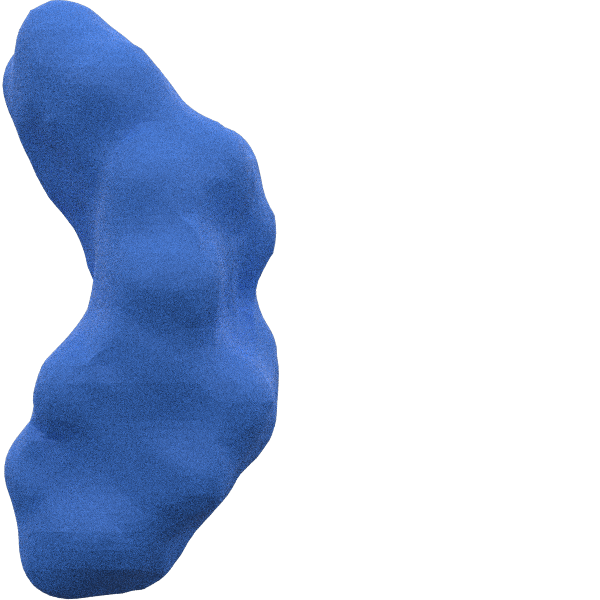

In [134]:
view='front'

n_samples = 50
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=v[f].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


In [135]:
f = open('mol.pdb', 'w')
f.write(Chem.MolToPDBBlock(mol.mol))
f.close()

In [136]:
import open3d as o3d
chimera_mesh = o3d.io.read_triangle_mesh('chimera.stl')

In [82]:
chimera_vertices = np.array(chimera_mesh.vertices)
chimera_faces = np.array(chimera_mesh.triangles)

In [88]:
plotly_scatter([chimera_vertices, vert, p*np.array([1,1,1])], [5, 3, 9])
#plotly_scatter([chimera_vertices], [3])

In [80]:
o3d.visualization.draw_geometries([chimera_mesh])

In [ ]:
n_samples = 50
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=chimera_vertices[chimera_faces].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


In [84]:
vmake_vol(chimera_vertices[chimera_faces]).sum()

DeviceArray(299.34955, dtype=float32)

In [85]:
vmake_vol((vert)[faces]).sum()

DeviceArray(292.17075, dtype=float32)

In [68]:
from rdkit.Chem.rdFreeSASA import CalcSASA

In [69]:
CalcSASA(mol.mol, list(radii))

523.1744997450389

In [70]:
ComputeMolVolume(mol.mol, 0)

247.58400000000006

In [4]:
import ipyvolume
data =ipyvolume.datasets.hdz2000.fetch()

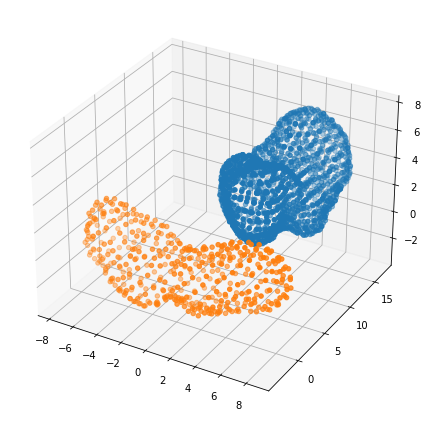

In [75]:
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(111, projection="3d")

n=1
ax.scatter(vert[:,0][::n], vert[:,1][::n], vert[:,2][::n])
ax.scatter(p[:,0], p[:,1], p[:,2])

plt.tight_layout()
plt.show()

In [408]:
t = o3d.geometry.TriangleMesh()
t.vertices = o3d.utility.Vector3dVector(v/2)
t.triangles = o3d.utility.Vector3iVector(f)
t.compute_vertex_normals()
t.compute_triangle_normals()
o3d.io.write_triangle_mesh('hi.stl', t)

#o3d.visualization.draw_geometries([t])
#t.get_volume()


True

In [416]:
t2 = o3d.geometry.TriangleMesh()
t2.vertices = o3d.utility.Vector3dVector(chimera_vertices)
t2.triangles = o3d.utility.Vector3iVector(chimera_faces)
t2.compute_vertex_normals()

o3d.visualization.draw_geometries([t2])

In [409]:
t.get_surface_area()

278.6882832159847

In [342]:
t2.get_surface_area()

338.85580607422986

In [326]:
import meshio 

points = np.array(vert)
cells = [("triangle", np.array(faces))]
meshio.write_points_cells('out.obj',points,cells)